<a href="https://colab.research.google.com/github/codyshen0000/My_Test_Code/blob/main/Normalizing_flows_in_PyTorch_(part_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced flows - autoregressive
## Quick recap
所谓的正则化流，就是利用一系列变量转换，来得到一个新的概率分布。如果初始随机变量为$z_0$，服从于分布$q_0$,我们可以应用一系列映射$f_i,i\in 1,\cdots,k 且 k\in N$，来得到$z_k$的分布
$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|
\tag{1} 
$$

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
from IPython.display import HTML
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])


class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)


class PlanarFlow(Flow):

    def __init__(self, dim, h=torch.tanh, hp=(lambda x: 1 - torch.tanh(x) ** 2)):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.h = h
        self.hp = hp
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.h(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = self.hp(f_z) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)


## Invertible generative flows
如果我们定义的transformations的雅克比是个对角矩阵，那么式子可以进一步简化：
$$
\text{log }\left|\det{\frac{\partial f}{\partial \mathbf{z}}}\right| = \sum_{i=1}^D \text{log }\left|diag\left(\frac{\partial f}{\partial \mathbf{z}}\right)\right|
\tag{2} 
$$
# Batch Normalization
$$
\begin{align}
\hat{\mathbf{x}_b} = \frac{\mathbf{x}_b-\tilde{\mu_b}}{\sqrt{\tilde{\sigma_b}^2 + \epsilon}}\\
f\left(\mathbf{x}\right)=\gamma\hat{\mathbf{x}_b}+\beta
\end{align}
\tag{3} 
$$
$\mathbf{x}_b$ is one batch of data,$\tilde{\mu_b}=\mathbb{E}\left[\mathbf{x}_b\right]$ and $\tilde{\sigma_b}^2=Var\left[\mathbf{x}_b\right]$ are this batch mean and variance.and $\gamma$ and $\beta$ are two trainable parameters representing shift and scale.
$$
\text{log }\left|\det{\frac{\partial f}{\partial \mathbf{x}}}\right| = \sum_{i=1}^D \left[ \text{log }\left(\gamma_i\right) - \frac{1}{2}\text{log }\left(\tilde{\sigma_i}^2 + \epsilon\right) \right]
\tag{4} 
$$

In [8]:
class BatchNormFlow(Flow):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

# Target densities and optimization

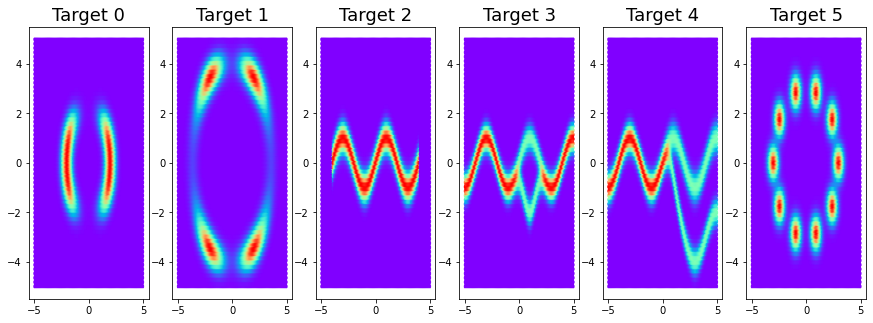

In [9]:
import math

w1 = lambda z: torch.sin(2 * math.pi * z[:, 0] / 4)
w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
w3 = lambda z: 3 * (1.0 / (1 + torch.exp(-(z[:, 0] - 1) / 0.3)))

def density_mvn(z, mu=torch.FloatTensor([[0, 0]]), sig=torch.FloatTensor([[1, 1]])):
    z = z[:, None, :] - mu[None, :, :]
    sig_inv = 1./sig
    exponent = -0.5 * torch.sum(z * sig_inv[None, :, :] * z, (1, 2))
    return torch.exp(exponent)

def density_bivar(z):
    add1 = 0.5 * ((torch.norm(z, 2, 1) - 2) / 0.4) ** 2
    add2 = -torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2) + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2))
    return torch.exp(-(add1 + add2))

def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

def density_wave(z):
    z = torch.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    u = 0.5 * ((z2 - w1(z))/0.4) ** 2
    u[torch.abs(z1) > 4] = 1e8
    return torch.exp(-u)

def density_wave_twist(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    return torch.exp(torch.log(in1 + in2 + 1e-9))

def density_wave_split(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    return torch.exp(torch.log(in1 + in2))
    
def density_circle(z, n_dens=10):
    full_dens = []
    for n in range(n_dens):
        x = math.cos((n / float(n_dens)) * 2 * math.pi) * 3
        y = math.sin((n / float(n_dens)) * 2 * math.pi) * 3
        full_dens.append(density_mvn(z, mu=torch.FloatTensor([[x, y]]), sig= 0.1 * torch.FloatTensor([[1, 2]])).unsqueeze(1))
    return torch.sum(torch.cat(full_dens, dim=1), dim=1)

x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
# Set of target densities
targets = [density_bivar, density_ring, density_wave, density_wave_twist, density_wave_split, density_circle]
# Plot these lads
plt.figure(figsize=(15, 5))
for t in range(len(targets)):
    plt.subplot(1, len(targets), t+1)
    plt.hexbin(z[:,0], z[:,1], C = targets[t](torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    plt.title('Target ' + str(t), fontsize=18);

In [11]:

# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
import torch.optim as optim
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

def train_flow(flow, loss, optimizer, scheduler, target_density, epochs=10001, plot_it=1000):
    ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
    ims = []
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    for it in range(epochs):
        # Draw a sample batch from Normal
        samples = ref_distrib.sample((512, ))
        # Evaluate flow of transforms
        zk, log_jacobians = flow(samples)
        # Evaluate loss and backprop
        #optimizer.zero_grad()
        loss_v = loss(target_density, zk, log_jacobians)
        loss_v.backward()
        optimizer.step()
        scheduler.step()
        if (it % plot_it == 0):
          print('Loss (it. %i) : %f'%(it, loss_v.item()))
          # Draw random samples
          with torch.no_grad():
            samples = ref_distrib.sample((int(1e5), ))
            # Evaluate flow and plot
            zk, _ = flow(samples)
            zk = zk.detach().numpy()
            im = plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow', animated='True')
            ims.append([im])
    # ax1.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    # ax1.set_title('Target density', fontsize=15);
    # ax2.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
    # ax2.set_title('Final approximation', fontsize=15)
    anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    HTML(anim.to_html5_video())
    anim.save("check.mp4")
    # ax3.set_title('Optimization process', fontsize=15)